<a href="https://colab.research.google.com/github/nerbivol/siamese_damage_detection/blob/main/Siamese_classify.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install tensorflow-addons

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import os
import glob
import pickle
import tqdm.notebook
import datetime
from pathlib import Path
from PIL import Image

import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import Input, Sequential, Model
from tensorflow.keras.applications.vgg16 import VGG16
from keras.layers import concatenate, Dense, BatchNormalization, Activation, MaxPool2D, Flatten, Conv2D
from keras.utils.np_utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow_addons.metrics import F1Score

/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [ ]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  print('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [ ]:
base_path = "/content/drive/MyDrive/Colab Notebooks"
folder_name = "DamageBuilding"

In [ ]:
damage_dict = {
    0: "no-damage",
    1: "minor-damage",
    2: "major-damage",
    3: "destroyed",
}

##Crop boundix boxs


In [ ]:
images_dir = f"{base_path}/{folder_name}/PostImages/train/images"
labels_dir = f"{base_path}/{folder_name}/PostImages/train/labels"

# pre_images = sorted(glob.glob(os.path.join(images_dir, "*pre*")))
post_images = sorted(glob.glob(os.path.join(images_dir, "*post*")))

# pre_label = sorted(glob.glob(os.path.join(labels_dir, "*pre*")))
# post_label = sorted(glob.glob(os.path.join(labels_dir, "*post*")))

# print("Pre images: ", len(pre_images))
print("Post images: ", len(post_images))

# print("Pre labels: ", len(pre_label))
# print("Post labels: ", len(post_label))

Post images:  6140


In [ ]:
# delete = []

# for im in pre_label:
#   if im.replace('labels', 'images').replace('.txt','.jpg') not in pre_images:
#     delete.append(im)

# delete

In [ ]:
# for d in delete:
#   os.remove(d)
#   os.remove(d.replace('pre', 'post'))

In [ ]:
output_pre_dir = f"{base_path}/{folder_name}/clasify/pre"

if not os.path.exists(output_pre_dir):
    os.makedirs(output_pre_dir)

output_post_dir = f"{base_path}/{folder_name}/clasify/post"

if not os.path.exists(output_post_dir):
    os.makedirs(output_post_dir)

In [ ]:
for image_file in tqdm.notebook.tqdm(post_images[5500:]):
    image_post = cv2.imread(image_file)
    image_pre = cv2.imread(image_file.replace('post','pre'))

    label_file = image_file.replace('images','labels').replace('jpg','txt')

    img_file = image_file.split("/")[-1]
    with open(label_file, "r") as f:
        lines = f.readlines()

    for i, line in enumerate(lines):
        class_id, center_x, center_y, width, height = map(float, line.split())

        x = int((center_x - width / 2) * image_post.shape[1])
        y = int((center_y - height / 2) * image_post.shape[0])
        w = int(width * image_post.shape[1])
        h = int(height * image_post.shape[0])
        
        cropped_image_post = image_post[y:y+h, x:x+w]
        cropped_image_pre = image_pre[y:y+h, x:x+w]
        
        class_name = damage_dict[int(class_id)]
        
        class_post_dir = os.path.join(output_post_dir, class_name)
        class_pre_dir = os.path.join(output_pre_dir, class_name)

        if not os.path.exists(class_post_dir):
            os.makedirs(class_post_dir)
        if not os.path.exists(class_pre_dir):
            os.makedirs(class_pre_dir)
        
        output_path = os.path.join(class_post_dir, f"{img_file[:-4]}_{i}.jpg")
        cv2.imwrite(output_path, cropped_image_post)
        cv2.imwrite(output_path.replace('post','pre'), cropped_image_pre)

  0%|          | 0/640 [00:00<?, ?it/s]

Видалимо зображення, які збереглися лише в одну папку(colab так вміє робити)

In [ ]:
delete=[]
damage=2
images_dir = f"{base_path}/{folder_name}/clasify/post/{damage_dict[damage]}/*"
post_images = glob.glob(images_dir)
print(len(post_images))

images_dir = f"{base_path}/{folder_name}/clasify/pre/{damage_dict[damage]}/*"
pre_images = glob.glob(images_dir)
print(len(pre_images))

for im in post_images:
  if im.replace('post', 'pre') not in pre_images:
    delete.append(im)

for im in pre_images:
  if im.replace('pre','post') not in post_images:
    delete.append(im)

8853
8853


In [ ]:
len(delete)

0

In [ ]:
for d in delete:
  os.remove(d)

На даному етапі обробки у нас багато зображнь, що містять непошкодженні будинки. Рандомним чином видалимо половину зображення

In [ ]:
no_damage_images, images_for_delete = train_test_split(post_images, train_size=0.7)

In [ ]:
len(no_damage_images)

22578

In [ ]:
for d in images_for_delete:
  os.remove(d)
  os.remove(d.replace('post', 'pre'))

# Build Siemese model

### Connect dataset from tf.data.Dataset

In [ ]:
from tensorflow.keras.preprocessing import image_dataset_from_directory

In [ ]:
data_post_dir = f"{base_path}/{folder_name}/clasify/post"
data_pre_dir = f"{base_path}/{folder_name}/clasify/pre"

batch_size = 64
input_img_shape = [64, 64]
AUTOTUNE = tf.data.experimental.AUTOTUNE

In [ ]:
for damage in range(4):
  images_dir = f"{base_path}/{folder_name}/clasify/pre/{damage_dict[damage]}/*"
  pre_images = glob.glob(images_dir)
  print(f"{damage_dict[damage]} pre images:  {len(pre_images)}")
  
  images_dir = f"{base_path}/{folder_name}/clasify/post/{damage_dict[damage]}/*"
  post_images = glob.glob(images_dir)
  print(f"{damage_dict[damage]} post images:  {len(post_images)}\n")

no-damage pre images:  22578
no-damage post images:  22578

minor-damage pre images:  8853
minor-damage post images:  8853

major-damage pre images:  4411
major-damage post images:  4411

destroyed pre images:  16719
destroyed post images:  16719



In [ ]:
train_post_ds = tf.keras.utils.image_dataset_from_directory(
  data_post_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=input_img_shape,
  batch_size=batch_size)

valid_post_ds = tf.keras.utils.image_dataset_from_directory(
  data_post_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=input_img_shape,
  batch_size=batch_size)


train_pre_ds = tf.keras.utils.image_dataset_from_directory(
  data_pre_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=input_img_shape,
  batch_size=batch_size)

valid_pre_ds = tf.keras.utils.image_dataset_from_directory(
  data_pre_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=input_img_shape,
  batch_size=batch_size)

Found 52561 files belonging to 4 classes.
Using 42049 files for training.
Found 52561 files belonging to 4 classes.
Using 10512 files for validation.
Found 52561 files belonging to 4 classes.
Using 42049 files for training.
Found 52561 files belonging to 4 classes.
Using 10512 files for validation.


In [ ]:
def process_data(pre, post):
  image1, label1 = pre
  image2, label2 = post

  return [image1, image2], label2

In [ ]:
zip_train_pairs = tf.data.Dataset.zip((train_pre_ds, train_post_ds), name=None)

train_batches = (
    zip_train_pairs
    .map(process_data)
)

zip_valid_pairs = tf.data.Dataset.zip((valid_pre_ds, valid_post_ds), name=None)

valid_batches = (
    zip_valid_pairs
    .map(process_data)
)

In [ ]:
history = similarity_model.fit_generator(train_batches,
                                         epochs=1,
                                         validation_data=valid_batches,
                                         callbacks=callbacks_list)

##Load and cache images

In [ ]:
image_cache = {}

In [ ]:
def load_image(image_name):
  image = Image.open(image_name)
  image = tf.image.resize(image, (64, 64))
  image = tf.image.per_image_standardization(image)
  image = tf.cast(image, tf.float16)
  return image

def generate_image_triples_batch(image_triples, batch_size, shuffle=False):
    while True:
        n = len(image_triples)
        
        if shuffle:
            indices = np.random.permutation(np.arange(n))
        else:
            indices = np.arange(n)
            
        shuffled_triples = [image_triples[ix] for ix in indices]
        num_batches = len(shuffled_triples) // batch_size

        for bid in range(num_batches):
            images_left, images_right, labels = [], [], []
            batch = shuffled_triples[bid * batch_size : (bid + 1) * batch_size]

            for i in range(batch_size):
                lhs, rhs, label = batch[i]
                # print(lhs)
                if lhs in image_cache:
                  l_image, r_image = image_cache[lhs]
                  images_left.append(l_image)
                  images_right.append(r_image)

                else:
                  l_image = load_image(lhs)
                  r_image = load_image(rhs)
                  images_left.append(l_image)
                  images_right.append(r_image)
                  image_cache[lhs] = [l_image, r_image]

                labels.append(label)

            left = np.array(images_left)
            right = np.array(images_right)
            Y = to_categorical(np.array(labels), num_classes=4)
            yield ([left, right], Y)

In [ ]:
triples = []

for damage in range(4):
  images_dir = f"{base_path}/{folder_name}/clasify/pre/{damage_dict[damage]}/*"
  pre_images = glob.glob(images_dir)
  print(f"{damage_dict[damage]} pre images:  {len(pre_images)}")
  
  images_dir = f"{base_path}/{folder_name}/clasify/post/{damage_dict[damage]}/*"
  post_images = glob.glob(images_dir)
  print(f"{damage_dict[damage]} post images:  {len(post_images)}\n")

  trip = np.column_stack((pre_images, post_images, [damage]*len(post_images)))
  
  triples.extend(trip)

no-damage pre images:  22578
no-damage post images:  22578

minor-damage pre images:  8853
minor-damage post images:  8853

major-damage pre images:  4411
major-damage post images:  4411

destroyed pre images:  16719
destroyed post images:  16719



In [ ]:
len(triples)

52561

In [ ]:
triples[0]

array(['/content/drive/MyDrive/Colab Notebooks/DamageBuilding/clasify/pre/no-damage/socal-fire_00001092_pre_1_1_4.jpg',
       '/content/drive/MyDrive/Colab Notebooks/DamageBuilding/clasify/post/no-damage/socal-fire_00000887_post_1_0_11.jpg',
       '0'], dtype='<U122')

In [ ]:
file_cache_name = f"{base_path}/{folder_name}/clasify/image_cache.pkl"

image_cache = pd.read_pickle(file_cache_name)

In [ ]:
triples_train, triples_valid = train_test_split(triples, train_size=0.8)

In [ ]:
del triples

In [ ]:
BATCH_SIZE = 64

train_gen = generate_image_triples_batch(triples_train, BATCH_SIZE, shuffle=True)
val_gen = generate_image_triples_batch(triples_valid, BATCH_SIZE, shuffle=False)

num_train_steps = len(triples_train) // BATCH_SIZE
num_val_steps = len(triples_valid) // BATCH_SIZE

In [ ]:
# for tripl in tqdm.notebook.tqdm(triples[30000:]):
#   lhs, rhs, label = tripl
#   l_image = load_image(lhs)
#   r_image = load_image(rhs)
#   image_cache[lhs] = [l_image, r_image]
  

  0%|          | 0/22561 [00:00<?, ?it/s]

In [ ]:
# file_cache_name = f"{base_path}/{folder_name}/clasify/image_cache_46px.pkl"

# # save dictionary to image_cache.pkl file
# with open(file_cache_name, 'wb') as fp:
#     pickle.dump(image_cache, fp, protocol=pickle.HIGHEST_PROTOCOL)
#     print('dictionary saved successfully to file')

dictionary saved successfully to file


compare time for load images and get images from cache


In [ ]:
%%timeit 
lhs, rhs, label = triples[0]
l_image = load_image(lhs)
r_image = load_image(rhs)

13.9 ms ± 2.87 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [ ]:
%%timeit
l_image, r_image = image_cache[triples[0][0]]

881 ns ± 291 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)


In [ ]:
callbacks_list = []

val_acc_name = f"val_accuracy"
# val_acc_name = f"val_f1_score"

timestamp = datetime.datetime.now().strftime("%Y%m%d-%H%M%S") 

models_dir = f"{base_path}/{folder_name}/clasify/model-checkpts/{timestamp}"
Path(models_dir).mkdir(parents=True, exist_ok=True)

model_filename = os.path.join(models_dir, f'model_{timestamp}_'+ f'{{epoch:03d}}_{{{val_acc_name}:.4f}}.h5')


log_dir = f"{base_path}/{folder_name}/clasify/logs/log-{timestamp}"
Path(log_dir).mkdir(parents=True, exist_ok=True)

callbacks_list.append([
                       tf.keras.callbacks.ModelCheckpoint(model_filename, 
                                       monitor=val_acc_name,
                                       mode="max", 
                                       save_best_only=True
                                       ),
                       tf.keras.callbacks.ReduceLROnPlateau(), # reduce learning rate when validation loss plateaus
                       tf.keras.callbacks.EarlyStopping(monitor=val_acc_name, patience=50), 
                       tf.keras.callbacks.TensorBoard(log_dir, histogram_freq=1, update_freq='batch')
])

print(f"A list of callbacks: \n{callbacks_list}")

A list of callbacks: 
[[<keras.callbacks.ModelCheckpoint object at 0x7fbdb3495060>, <keras.callbacks.ReduceLROnPlateau object at 0x7fbdb3497220>, <keras.callbacks.EarlyStopping object at 0x7fbdbd26f520>, <keras.callbacks.TensorBoard object at 0x7fbdbd26f4c0>]]


In [ ]:
def plot_history(history):
  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 8))

  # Plot training & validation loss values
  ax1.plot(history.history['loss'])
  ax1.plot(history.history['val_loss'])
  ax1.set_title('Model loss')
  ax1.grid()
  ax1.set_ylabel('Loss')
  ax1.set_xlabel('Epoch')
  ax1.legend(['Train', 'Validation'], loc='upper left')

  # Plot training & validation accuracy values
  ax2.plot(history.history['accuracy'])
  ax2.plot(history.history['val_accuracy'])

  ax2.plot(history.history['f1_score'])
  ax2.plot(history.history['val_f1_score'])

  ax2.plot(history.history['auc'])
  ax2.plot(history.history['val_auc'])

  ax2.set_title('Model accuracy')
  ax2.grid()
  ax2.set_ylabel('Accuracy')
  ax2.set_xlabel('Epoch')
  ax2.legend(['Train accuracy', 'Validation accuracy', 'Train f1 score', 'Validation f1 score', 'Train AUC', 'Validation AUC'], loc='lower right')
  plt.show()

## VGG16


In [ ]:
base_model = VGG16(weights='imagenet', input_shape=(64, 64, 3), pooling='max', include_top = False)

base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 64, 64, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 64, 64, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 32, 32, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 32, 32, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 32, 32, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 16, 16, 128)       0     

In [ ]:
input_image_a = Input(shape=(64, 64, 3), name = 'input_image_a')
input_image_b = Input(shape=(64, 64, 3), name = 'input_image_b')

feat_image_a = base_model(input_image_a)
feat_image_b = base_model(input_image_b)

combined_features = concatenate([feat_image_a, feat_image_b], name = 'merge_features')

combined_features = Dense(512, activation = 'linear')(combined_features)
combined_features = BatchNormalization()(combined_features)
combined_features = Activation('relu')(combined_features)

combined_features = Dense(256, activation = 'linear')(combined_features)
combined_features = BatchNormalization()(combined_features)
combined_features = Activation('relu')(combined_features)

combined_features = Dense(128, activation = 'linear')(combined_features)
combined_features = BatchNormalization()(combined_features)
combined_features = Activation('relu')(combined_features)

combined_features = Dense(64, activation = 'linear')(combined_features)
combined_features = BatchNormalization()(combined_features)
combined_features = Activation('relu')(combined_features)

combined_features = Dense(32, activation = 'linear')(combined_features)
combined_features = BatchNormalization()(combined_features)
combined_features = Activation('relu')(combined_features)

combined_features = Dense(16, activation = 'linear')(combined_features)
combined_features = BatchNormalization()(combined_features)
combined_features = Activation('relu')(combined_features)

combined_features = Dense(8, activation = 'linear')(combined_features)
combined_features = BatchNormalization()(combined_features)
combined_features = Activation('relu')(combined_features)

combined_features = Dense(4, activation = 'softmax')(combined_features)
similarity_model = Model(inputs = [input_image_a, input_image_b], outputs = [combined_features], name = 'Similarity_Model')
similarity_model.summary()

Model: "Similarity_Model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_image_a (InputLayer)     [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 input_image_b (InputLayer)     [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 vgg16 (Functional)             (None, 512)          14714688    ['input_image_a[0][0]',          
                                                                  'input_image_b[0][0]']          
                                                                                                  
 merge_features (Concatenate)   (None, 1024)         0           ['vgg16[0][0]',   

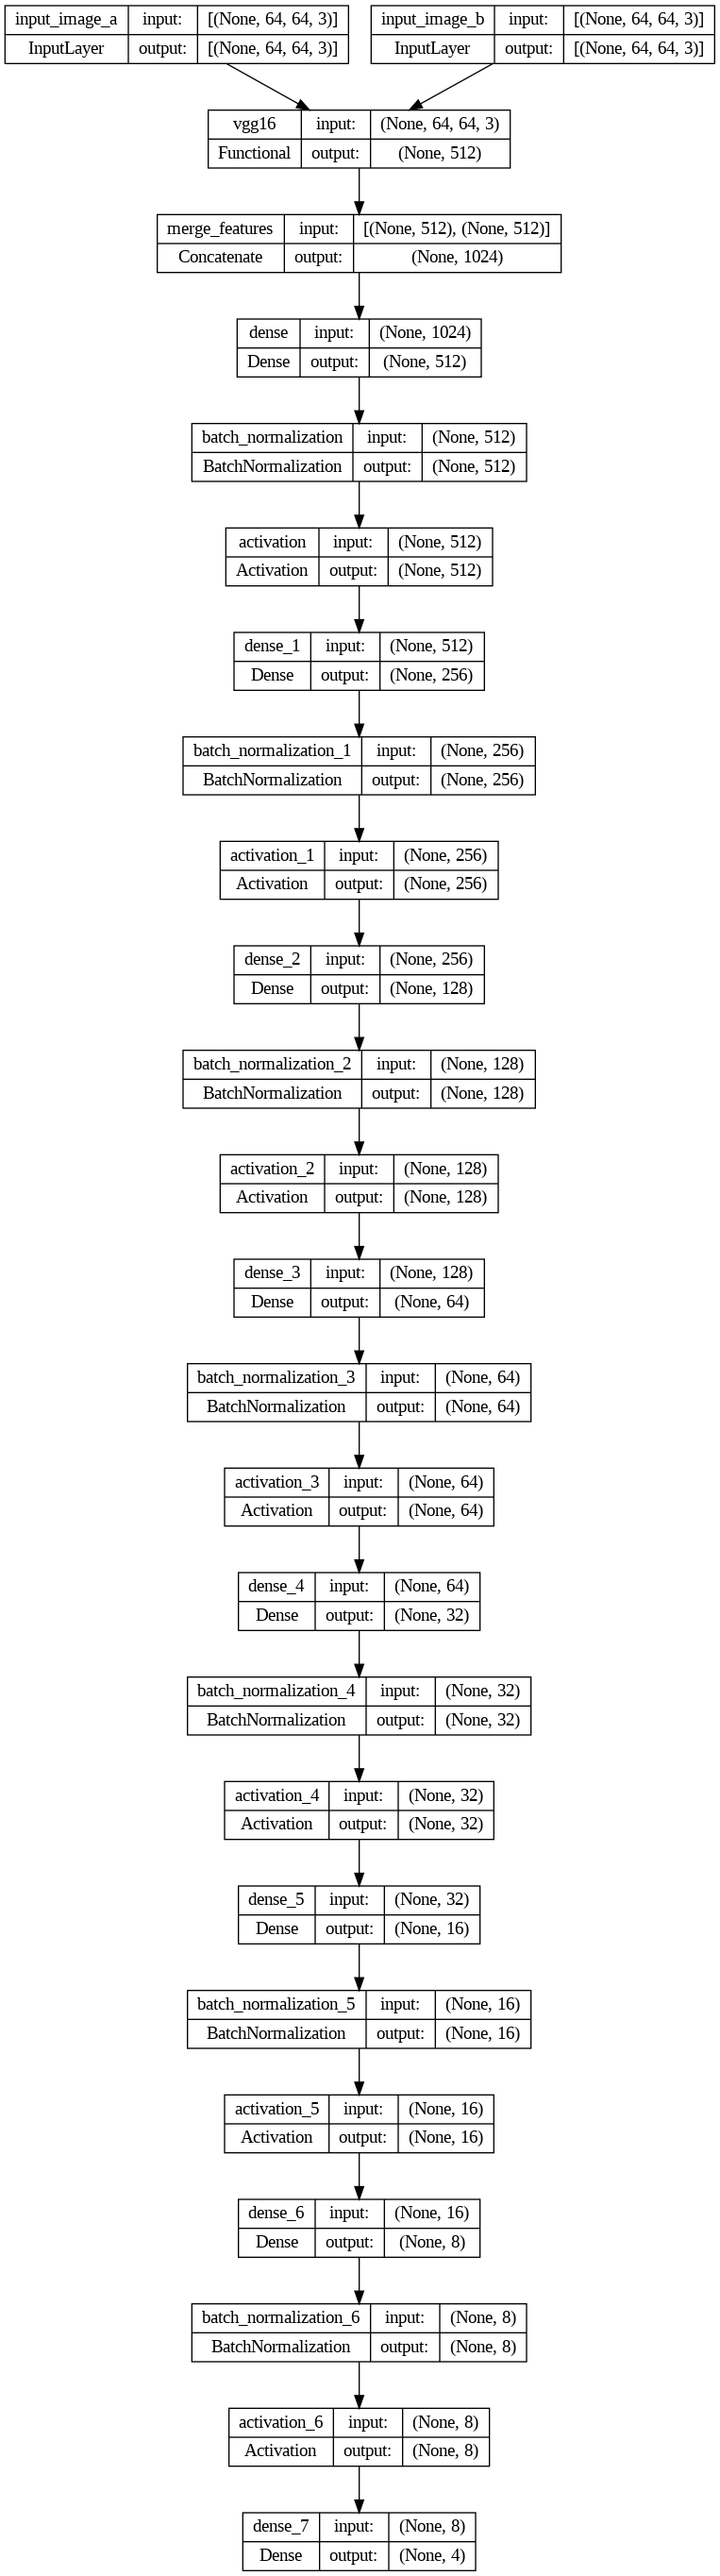

In [ ]:
tf.keras.utils.plot_model(similarity_model, show_shapes=True)

In [ ]:
similarity_model.compile(loss="categorical_crossentropy", 
                         optimizer="adam", 
                         metrics=[F1Score(num_classes=4, average='macro', threshold=0.5),
                                  "accuracy"
                                  ])

In [ ]:
history = similarity_model.fit_generator(train_gen,
                                         steps_per_epoch=num_train_steps,
                                         epochs=30,
                                         validation_data=val_gen,
                                         validation_steps=num_val_steps,
                                         callbacks=callbacks_list)

Epoch 1/30


<ipython-input-22-78b098239e99>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = similarity_model.fit_generator(train_gen,


657/657 [==============================] - 146s 201ms/step - loss: 1.0573 - f1_score: 0.2684 - accuracy: 0.5555 - val_loss: 1.6669 - val_f1_score: 0.1896 - val_accuracy: 0.4161 - lr: 0.0010
Epoch 2/30
657/657 [==============================] - 122s 185ms/step - loss: 0.9325 - f1_score: 0.3263 - accuracy: 0.6073 - val_loss: 0.8961 - val_f1_score: 0.3567 - val_accuracy: 0.6364 - lr: 0.0010
Epoch 3/30
657/657 [==============================] - 121s 184ms/step - loss: 0.8452 - f1_score: 0.4375 - accuracy: 0.6577 - val_loss: 1.2633 - val_f1_score: 0.2171 - val_accuracy: 0.4763 - lr: 0.0010
Epoch 4/30
657/657 [==============================] - 122s 185ms/step - loss: 0.7712 - f1_score: 0.5040 - accuracy: 0.6989 - val_loss: 0.7748 - val_f1_score: 0.5375 - val_accuracy: 0.7020 - lr: 0.0010
Epoch 5/30
657/657 [==============================] - 121s 184ms/step - loss: 0.7152 - f1_score: 0.5390 - accuracy: 0.7223 - val_loss: 0.6994 - val_f1_score: 0.5830 - val_accuracy: 0.7358 - lr: 0.0010
Epoch 

In [ ]:
val_acc = history.history[f"val_accuracy"]
best_epoch = np.argmax(val_acc)
best_value = val_acc[best_epoch]
print(f'The best epoch: {best_epoch + 1}, and its the best accuracy value: {100*best_value:.2f}%')

val_f1 = history.history[f"val_f1_score"]
best_epoch = np.argmax(val_f1)
best_value = val_f1[best_epoch]
print(f'The best epoch: {best_epoch + 1}, and its the best f1 value: {100*best_value:.2f}%')

The best epoch: 15, and its the best accuracy value: 76.83%
The best epoch: 17, and its the best f1 value: 65.29%


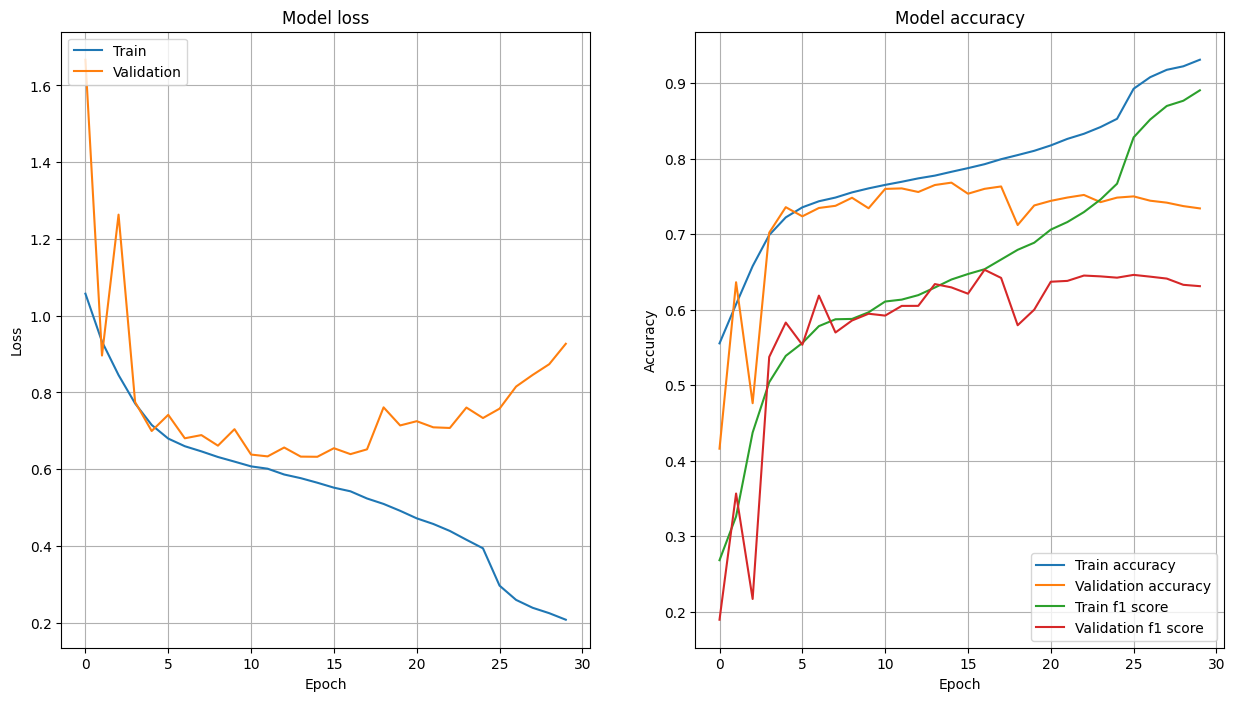

In [ ]:
plot_history(history)

In [ ]:
val_acc = history.history[f"val_accuracy"]
best_epoch = np.argmax(val_acc)
best_value = val_acc[best_epoch]
print(f'The best epoch: {best_epoch + 1}, and its the best accuracy value: {100*best_value:.2f}%')

val_auc = history.history[f"val_auc"]
best_epoch = np.argmax(val_auc)
best_value = val_auc[best_epoch]
print(f'The best epoch: {best_epoch + 1}, and its the best auc value: {100*best_value:.2f}%')


The best epoch: 14, and its the best accuracy value: 76.42%
The best epoch: 14, and its the best auc value: 93.56%


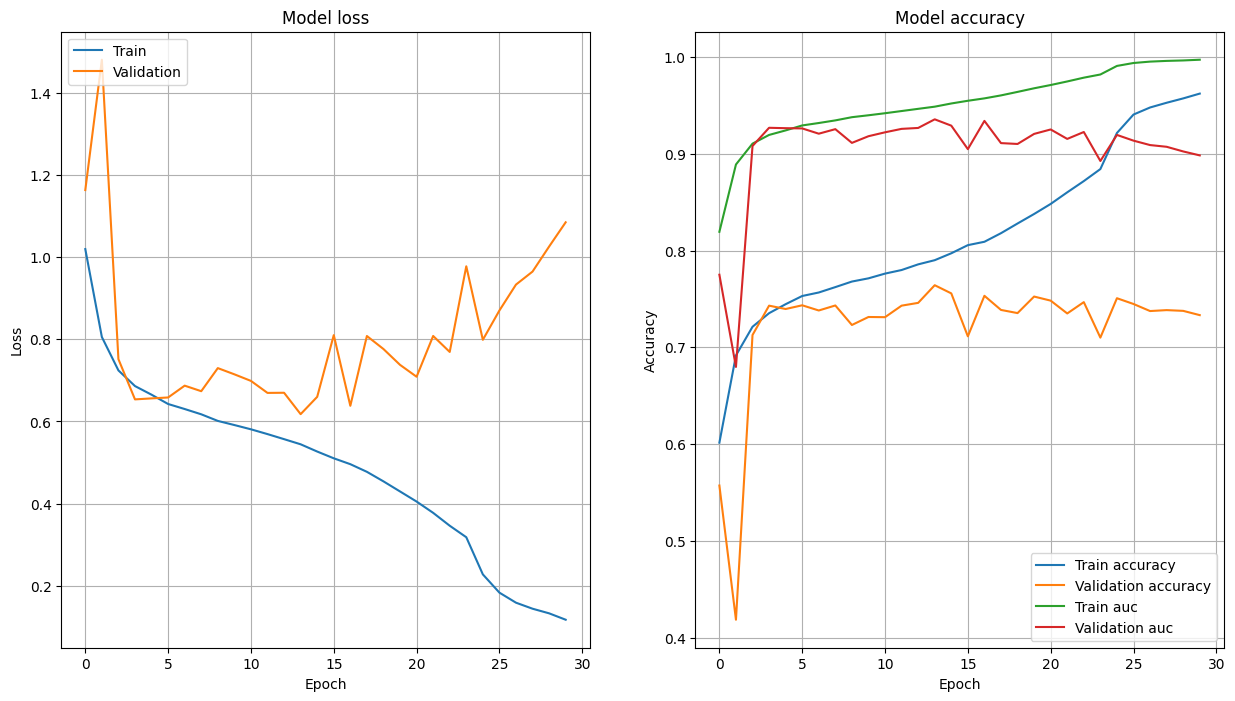

In [ ]:
plot_history(history)

##ResNet


In [ ]:
from tensorflow.keras.applications.resnet50 import ResNet50

base_model = ResNet50(weights='imagenet', input_shape=(64, 64, 3), pooling='max', include_top = False)

base_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 70, 70, 3)    0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 32, 32, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 32, 32, 64)   256         ['conv1_conv[0][0]']             
                                                                                           

In [ ]:
input_image_a = Input(shape=(64, 64, 3), name = 'input_image_a')
input_image_b = Input(shape=(64, 64, 3), name = 'input_image_b')

feat_image_a = base_model(input_image_a)
feat_image_b = base_model(input_image_b)

combined_features = concatenate([feat_image_a, feat_image_b], name = 'merge_features')

combined_features = Dense(512, activation = 'linear')(combined_features)
combined_features = BatchNormalization()(combined_features)
combined_features = Activation('relu')(combined_features)

combined_features = Dense(256, activation = 'linear')(combined_features)
combined_features = BatchNormalization()(combined_features)
combined_features = Activation('relu')(combined_features)

combined_features = Dense(128, activation = 'linear')(combined_features)
combined_features = BatchNormalization()(combined_features)
combined_features = Activation('relu')(combined_features)

combined_features = Dense(64, activation = 'linear')(combined_features)
combined_features = BatchNormalization()(combined_features)
combined_features = Activation('relu')(combined_features)

combined_features = Dense(32, activation = 'linear')(combined_features)
combined_features = BatchNormalization()(combined_features)
combined_features = Activation('relu')(combined_features)

combined_features = Dense(16, activation = 'linear')(combined_features)
combined_features = BatchNormalization()(combined_features)
combined_features = Activation('relu')(combined_features)

combined_features = Dense(8, activation = 'linear')(combined_features)
combined_features = BatchNormalization()(combined_features)
combined_features = Activation('relu')(combined_features)

combined_features = Dense(4, activation = 'softmax')(combined_features)
similarity_model_resnet = Model(inputs = [input_image_a, input_image_b], outputs = [combined_features], name = 'Similarity_Model')
similarity_model_resnet.summary()

Model: "Similarity_Model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_image_a (InputLayer)     [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 input_image_b (InputLayer)     [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 resnet50 (Functional)          (None, 2048)         23587712    ['input_image_a[0][0]',          
                                                                  'input_image_b[0][0]']          
                                                                                                  
 merge_features (Concatenate)   (None, 4096)         0           ['resnet50[0][0]',

In [ ]:
similarity_model_resnet.compile(loss="categorical_crossentropy", 
                         optimizer="adam", 
                         metrics=[F1Score(num_classes=4, average='macro', threshold=0.5),
                                  tf.keras.metrics.AUC(), 
                                  "accuracy"])

history_resnet = similarity_model_resnet.fit_generator(train_gen,
                                         steps_per_epoch=num_train_steps,
                                         epochs=30,
                                         validation_data=val_gen,
                                         validation_steps=num_val_steps,
                                         callbacks=callbacks_list)

Epoch 1/30


<ipython-input-20-02b19b917b13>:7: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history_resnet = similarity_model_resnet.fit_generator(train_gen,


657/657 [==============================] - 214s 214ms/step - loss: 0.8921 - f1_score: 0.4314 - auc_1: 0.8659 - accuracy: 0.6535 - val_loss: 124.4456 - val_f1_score: 0.3707 - val_auc_1: 0.6842 - val_accuracy: 0.5149 - lr: 0.0010
Epoch 2/30
657/657 [==============================] - 134s 203ms/step - loss: 0.7351 - f1_score: 0.5293 - auc_1: 0.9078 - accuracy: 0.7136 - val_loss: 0.9454 - val_f1_score: 0.4984 - val_auc_1: 0.8725 - val_accuracy: 0.6544 - lr: 0.0010
Epoch 3/30
657/657 [==============================] - 131s 199ms/step - loss: 0.6899 - f1_score: 0.5582 - auc_1: 0.9187 - accuracy: 0.7300 - val_loss: 0.6949 - val_f1_score: 0.5737 - val_auc_1: 0.9200 - val_accuracy: 0.7291 - lr: 0.0010
Epoch 4/30
657/657 [==============================] - 135s 205ms/step - loss: 0.6397 - f1_score: 0.5851 - auc_1: 0.9300 - accuracy: 0.7505 - val_loss: 0.6955 - val_f1_score: 0.5618 - val_auc_1: 0.9192 - val_accuracy: 0.7303 - lr: 0.0010
Epoch 5/30
657/657 [==============================] - 134s 20

In [ ]:
val_acc = history_resnet.history[f"val_accuracy"]
best_epoch = np.argmax(val_acc)
best_value = val_acc[best_epoch]
print(f'The best epoch: {best_epoch + 1}, and its the best accuracy value: {100*best_value:.2f}%')

val_auc = history_resnet.history[f"val_auc_1"]
best_epoch = np.argmax(val_auc)
best_value = val_auc[best_epoch]
print(f'The best epoch: {best_epoch + 1}, and its the best auc value: {100*best_value:.2f}%')

val_f1 = history_resnet.history[f"val_f1_score"]
best_epoch = np.argmax(val_f1)
best_value = val_f1[best_epoch]
print(f'The best epoch: {best_epoch + 1}, and its the best auc value: {100*best_value:.2f}%')

The best epoch: 10, and its the best accuracy value: 75.20%
The best epoch: 10, and its the best auc value: 93.04%
The best epoch: 18, and its the best auc value: 63.84%


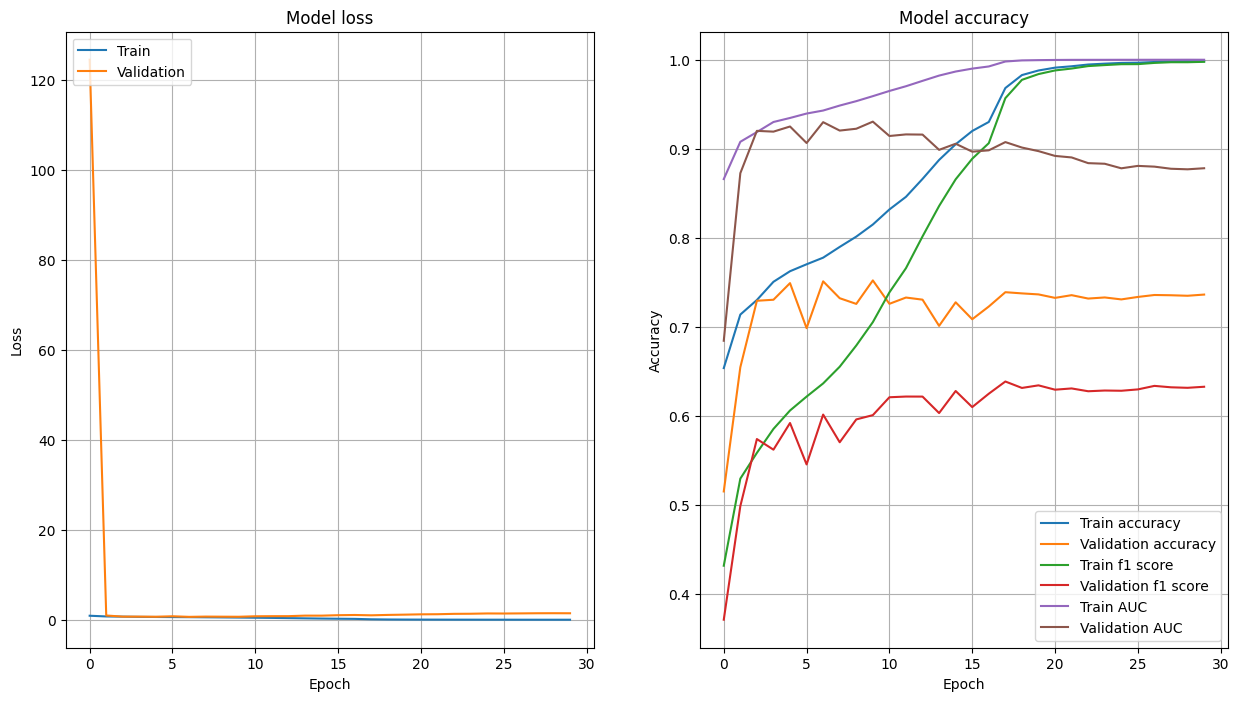

In [ ]:
plot_history(history_resnet)

## MobileNet


In [ ]:
from tensorflow.keras.applications.mobilenet import MobileNet

In [ ]:
base_model = MobileNet(weights='imagenet', input_shape=(64, 64, 3), pooling='max', include_top = False)

base_model.summary()

17225924/17225924 [==============================] - 2s 0us/step
Model: "mobilenet_1.00_224"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 conv1 (Conv2D)              (None, 32, 32, 32)        864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 32, 32, 32)       128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 32, 32, 32)        0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 32, 32, 32)       288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 32, 32, 32) 

In [ ]:
input_image_a = Input(shape=(64, 64, 3), name = 'input_image_a')
input_image_b = Input(shape=(64, 64, 3), name = 'input_image_b')

feat_image_a = base_model(input_image_a)
feat_image_b = base_model(input_image_b)

combined_features = concatenate([feat_image_a, feat_image_b], name = 'merge_features')

combined_features = layers.Dense(512, activation = 'linear')(combined_features)
combined_features = layers.BatchNormalization()(combined_features)
combined_features = layers.Activation('relu')(combined_features)

combined_features = layers.Dense(256, activation = 'linear')(combined_features)
combined_features = layers.BatchNormalization()(combined_features)
combined_features = layers.Activation('relu')(combined_features)

combined_features = layers.Dense(128, activation = 'linear')(combined_features)
combined_features = layers.BatchNormalization()(combined_features)
combined_features = layers.Activation('relu')(combined_features)

combined_features = layers.Dense(64, activation = 'linear')(combined_features)
combined_features = layers.BatchNormalization()(combined_features)
combined_features = layers.Activation('relu')(combined_features)

combined_features = layers.Dense(32, activation = 'linear')(combined_features)
combined_features = layers.BatchNormalization()(combined_features)
combined_features = layers.Activation('relu')(combined_features)

combined_features = layers.Dense(16, activation = 'linear')(combined_features)
combined_features = layers.BatchNormalization()(combined_features)
combined_features = layers.Activation('relu')(combined_features)

combined_features = layers.Dense(8, activation = 'linear')(combined_features)
combined_features = layers.BatchNormalization()(combined_features)
combined_features = layers.Activation('relu')(combined_features)

combined_features = layers.Dense(4, activation = 'softmax')(combined_features)
similarity_model_mobile = tf.keras.Model(inputs = [input_image_a, input_image_b], outputs = [combined_features], name = 'Similarity_Model')
similarity_model_mobile.summary()

Model: "Similarity_Model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_image_a (InputLayer)     [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 input_image_b (InputLayer)     [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 mobilenet_1.00_224 (Functional  (None, 1024)        3228864     ['input_image_a[0][0]',          
 )                                                                'input_image_b[0][0]']          
                                                                                                  
 merge_features (Concatenate)   (None, 2048)         0           ['mobilenet_1.00_2

In [ ]:
similarity_model_mobile.compile(loss="categorical_crossentropy", 
                         optimizer="adam", 
                         metrics=["accuracy"])

history_mobile = similarity_model_mobile.fit_generator(train_gen,
                                         steps_per_epoch=num_train_steps,
                                         epochs=30,
                                         validation_data=val_gen,
                                         validation_steps=num_val_steps,
                                         callbacks=callbacks_list)

<ipython-input-17-579aeb7a671e>:5: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history_mobile = similarity_model_mobile.fit_generator(train_gen,


Epoch 1/30
339/339 [==============================] - 104s 191ms/step - loss: 0.8670 - accuracy: 0.6658 - val_loss: 0.8490 - val_accuracy: 0.7034 - lr: 0.0010
Epoch 2/30
339/339 [==============================] - 51s 151ms/step - loss: 0.6231 - accuracy: 0.7636 - val_loss: 0.7747 - val_accuracy: 0.7296 - lr: 0.0010
Epoch 3/30
339/339 [==============================] - 50s 146ms/step - loss: 0.5657 - accuracy: 0.7851 - val_loss: 0.8189 - val_accuracy: 0.7177 - lr: 0.0010
Epoch 4/30
339/339 [==============================] - 53s 157ms/step - loss: 0.5323 - accuracy: 0.7962 - val_loss: 0.7070 - val_accuracy: 0.7408 - lr: 0.0010
Epoch 5/30
339/339 [==============================] - 50s 148ms/step - loss: 0.4978 - accuracy: 0.8112 - val_loss: 0.9115 - val_accuracy: 0.6922 - lr: 0.0010
Epoch 6/30
339/339 [==============================] - 51s 149ms/step - loss: 0.4754 - accuracy: 0.8183 - val_loss: 0.7482 - val_accuracy: 0.7273 - lr: 0.0010
Epoch 7/30
339/339 [==============================]

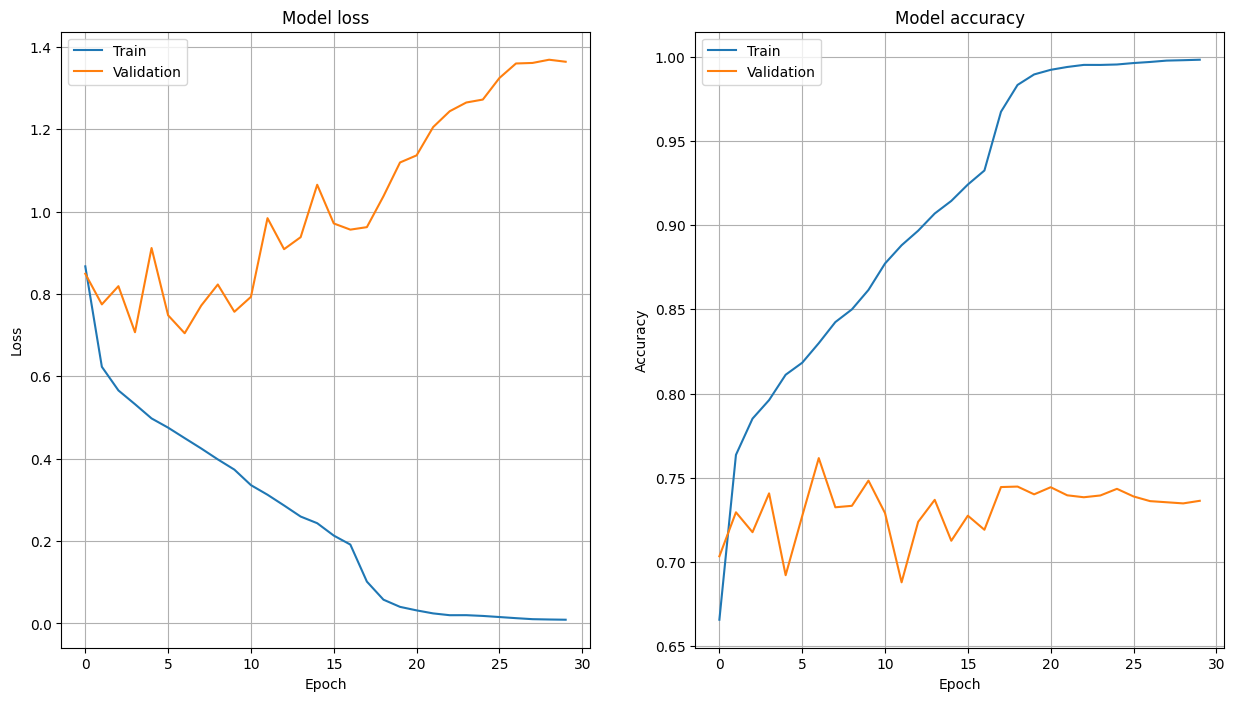

In [ ]:
plot_history(history_mobile)

## Custom vgg16


In [ ]:
model = Sequential()
# block #1 
model.add(Conv2D(filters=64, kernel_size=(3,3), strides=(1,1), activation='relu', padding='same', input_shape=(64,64, 3)))
model.add(Conv2D(filters=64, kernel_size=(3,3), strides=(1,1), activation='relu', padding='same')) 
model.add(MaxPool2D((2,2), strides=(2,2)))
# block #2 
model.add(Conv2D(filters=128, kernel_size=(3,3), strides=(1,1), activation='relu', padding='same'))
model.add(Conv2D(filters=128, kernel_size=(3,3), strides=(1,1), activation='relu', padding='same')) 
model.add(MaxPool2D((2,2), strides=(2,2)))
# block #3 
model.add(Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), activation='relu', padding='same'))
model.add(Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), activation='relu', padding='same'))
model.add(Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), activation='relu', padding='same')) 
model.add(MaxPool2D((2,2), strides=(2,2)))

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_7 (Conv2D)           (None, 64, 64, 64)        1792      
                                                                 
 conv2d_8 (Conv2D)           (None, 64, 64, 64)        36928     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 32, 32, 64)       0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 32, 32, 128)       73856     
                                                                 
 conv2d_10 (Conv2D)          (None, 32, 32, 128)       147584    
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 16, 16, 128)      0         
 2D)                                                  

In [ ]:
input_image_a = Input(shape=(64, 64, 3), name = 'input_image_a')
input_image_b = Input(shape=(64, 64, 3), name = 'input_image_b')

feat_image_a = model(input_image_a)
feat_image_b = model(input_image_b)

combined_features = concatenate([feat_image_a, feat_image_b], name = 'merge_features')

combined_features = Dense(256, activation = 'linear')(combined_features)
combined_features = BatchNormalization()(combined_features)
combined_features = Activation('relu')(combined_features)

combined_features = Dense(128, activation = 'linear')(combined_features)
combined_features = BatchNormalization()(combined_features)
combined_features = Activation('relu')(combined_features)

combined_features = Dense(64, activation = 'linear')(combined_features)
combined_features = BatchNormalization()(combined_features)
combined_features = Activation('relu')(combined_features)

combined_features = Dense(32, activation = 'linear')(combined_features)
combined_features = BatchNormalization()(combined_features)
combined_features = Activation('relu')(combined_features)

combined_features = Dense(16, activation = 'linear')(combined_features)
combined_features = BatchNormalization()(combined_features)
combined_features = Activation('relu')(combined_features)

combined_features = Dense(8, activation = 'linear')(combined_features)
combined_features = BatchNormalization()(combined_features)
combined_features = Activation('relu')(combined_features)

combined_features = Flatten()(combined_features)
combined_features = Dense(256, activation='relu')(combined_features)

combined_features = Dense(4, activation = 'softmax')(combined_features)
similarity_model = Model(inputs = [input_image_a, input_image_b], outputs = [combined_features], name = 'Similarity_Model')
similarity_model.summary()

Model: "Similarity_Model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_image_a (InputLayer)     [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 input_image_b (InputLayer)     [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 sequential_1 (Sequential)      (None, 8, 8, 256)    1735488     ['input_image_a[0][0]',          
                                                                  'input_image_b[0][0]']          
                                                                                                  
 merge_features (Concatenate)   (None, 8, 8, 512)    0           ['sequential_1[6][

In [ ]:
similarity_model.compile(loss="categorical_crossentropy", 
                         optimizer="adam", 
                         metrics=["accuracy"])

history = similarity_model.fit_generator(train_gen,
                                         steps_per_epoch=num_train_steps,
                                         epochs=30,
                                         validation_data=val_gen,
                                         validation_steps=num_val_steps,
                                         callbacks=callbacks_list)

Epoch 1/30


<ipython-input-30-c402fba6a79f>:5: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = similarity_model.fit_generator(train_gen,


339/339 [==============================] - 86s 212ms/step - loss: 0.9828 - accuracy: 0.6052 - val_loss: 1.1675 - val_accuracy: 0.4963 - lr: 0.0010
Epoch 2/30
339/339 [==============================] - 71s 209ms/step - loss: 0.7745 - accuracy: 0.6966 - val_loss: 0.7667 - val_accuracy: 0.7080 - lr: 0.0010
Epoch 3/30
339/339 [==============================] - 71s 208ms/step - loss: 0.7091 - accuracy: 0.7222 - val_loss: 0.8260 - val_accuracy: 0.6832 - lr: 0.0010
Epoch 4/30
339/339 [==============================] - 70s 208ms/step - loss: 0.6762 - accuracy: 0.7360 - val_loss: 0.7553 - val_accuracy: 0.7164 - lr: 0.0010
Epoch 5/30
339/339 [==============================] - 71s 208ms/step - loss: 0.6516 - accuracy: 0.7469 - val_loss: 0.9033 - val_accuracy: 0.6948 - lr: 0.0010
Epoch 6/30
339/339 [==============================] - 70s 208ms/step - loss: 0.6262 - accuracy: 0.7550 - val_loss: 0.7304 - val_accuracy: 0.7252 - lr: 0.0010
Epoch 7/30
339/339 [==============================] - 70s 207ms

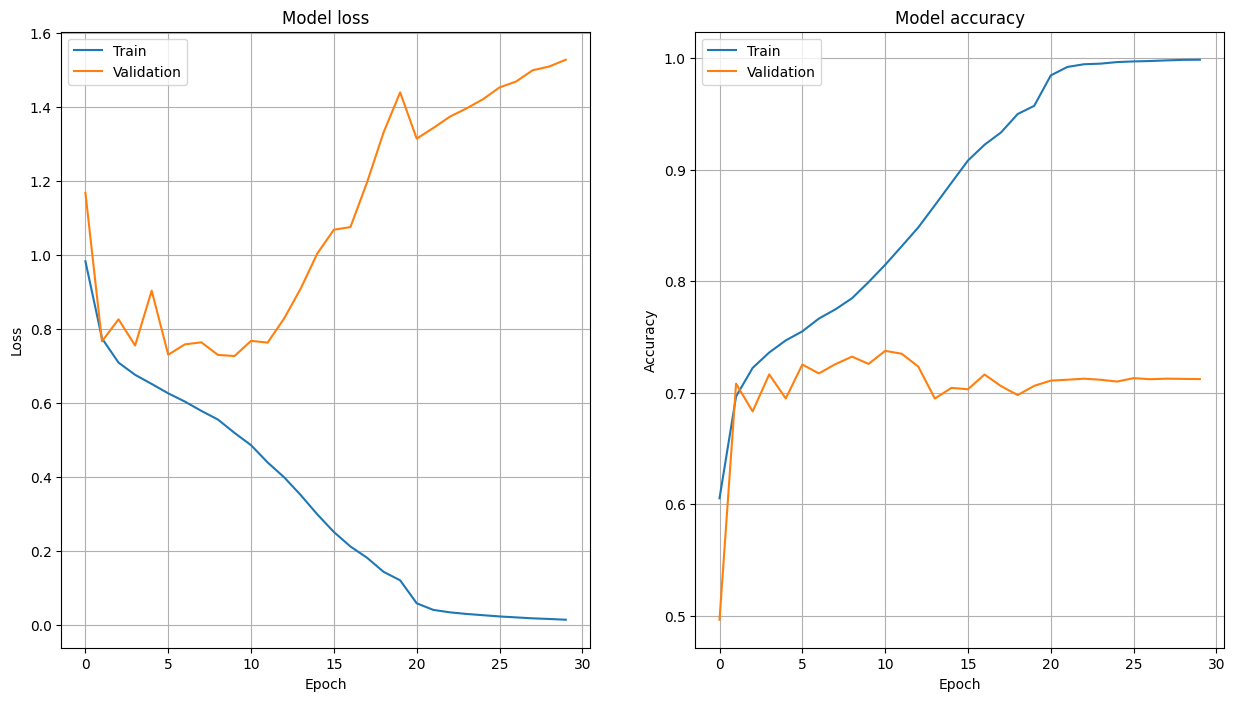

In [ ]:
plot_history(history)

## Standart classification


In [ ]:
def generate_image_batch(image_triples, batch_size, shuffle=False):
    while True:
        n = len(image_triples)
        
        if shuffle:
            indices = np.random.permutation(np.arange(n))
        else:
            indices = np.arange(n)
            
        shuffled_triples = [image_triples[ix] for ix in indices]
        num_batches = len(shuffled_triples) // batch_size

        for bid in range(num_batches):
            images_left, images_right, labels = [], [], []
            batch = shuffled_triples[bid * batch_size : (bid + 1) * batch_size]

            for i in range(batch_size):
                lhs, rhs, label = batch[i]
                # print(lhs)
                if lhs in image_cache:
                  l_image, r_image = image_cache[lhs]
                  images_left.append(l_image)
                  images_right.append(r_image)

                else:
                  l_image = load_image(lhs)
                  r_image = load_image(rhs)
                  images_left.append(l_image)
                  images_right.append(r_image)
                  image_cache[lhs] = [l_image, r_image]

                labels.append(label)

            right = np.array(images_right)
            Y = to_categorical(np.array(labels), num_classes=4)
            yield (right, Y)

In [ ]:
BATCH_SIZE = 124

train_gen = generate_image_batch(triples_train, BATCH_SIZE, shuffle=True)
val_gen = generate_image_batch(triples_valid, BATCH_SIZE, shuffle=False)

num_train_steps = len(triples_train) // BATCH_SIZE
num_val_steps = len(triples_valid) // BATCH_SIZE

In [ ]:
base_model = VGG16(weights='imagenet', input_shape=(64, 64, 3), pooling='max', include_top = False)

inputs = Input(shape=(64, 64, 3))
x = base_model(inputs)
x = Dense(32,activation='relu')(x) 
output = Dense(4, activation='sigmoid')(x)

model = tf.keras.Model(inputs=[inputs], outputs=[output])

#In the summary, weights and layers from VGG part will be hidden, but they will be fit during the training
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 vgg16 (Functional)          (None, 512)               14714688  
                                                                 
 dense_8 (Dense)             (None, 32)                16416     
                                                                 
 dense_9 (Dense)             (None, 4)                 132       
                                                                 
Total params: 14,731,236
Trainable params: 14,731,236
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.compile(loss="categorical_crossentropy", 
                         optimizer="adam", 
                         metrics=[tf.keras.metrics.AUC(), "accuracy"])

In [ ]:
history_class = model.fit_generator(train_gen,
                                    steps_per_epoch=num_train_steps,
                                    epochs=30,
                                    validation_data=val_gen,
                                    validation_steps=num_val_steps,
                                    callbacks=callbacks_list)

Epoch 1/30


<ipython-input-43-9a69f480f256>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history_class = model.fit_generator(train_gen,


381/381 [==============================] - 68s 154ms/step - loss: 0.9716 - auc_1: 0.8126 - accuracy: 0.5891 - val_loss: 0.8393 - val_auc_1: 0.8606 - val_accuracy: 0.6486 - lr: 0.0010
Epoch 2/30
381/381 [==============================] - 58s 153ms/step - loss: 0.8522 - auc_1: 0.8533 - accuracy: 0.6486 - val_loss: 0.8508 - val_auc_1: 0.8617 - val_accuracy: 0.6575 - lr: 0.0010
Epoch 3/30
381/381 [==============================] - 59s 154ms/step - loss: 0.8123 - auc_1: 0.8611 - accuracy: 0.6726 - val_loss: 0.7550 - val_auc_1: 0.8754 - val_accuracy: 0.6960 - lr: 0.0010
Epoch 4/30
381/381 [==============================] - 60s 157ms/step - loss: 0.7839 - auc_1: 0.8617 - accuracy: 0.6864 - val_loss: 0.7529 - val_auc_1: 0.8655 - val_accuracy: 0.6976 - lr: 0.0010
Epoch 5/30
381/381 [==============================] - 60s 156ms/step - loss: 0.7520 - auc_1: 0.8653 - accuracy: 0.7000 - val_loss: 0.7207 - val_auc_1: 0.8858 - val_accuracy: 0.7095 - lr: 0.0010
Epoch 6/30
381/381 [=====================

In [ ]:
val_acc = history_class.history[f"val_accuracy"]
best_epoch = np.argmax(val_acc)
best_value = val_acc[best_epoch]
print(f'The best epoch: {best_epoch + 1}, and its the best accuracy value: {100*best_value:.2f}%')

val_auc = history_class.history[f"val_auc_1"]
best_epoch = np.argmax(val_auc)
best_value = val_auc[best_epoch]
print(f'The best epoch: {best_epoch + 1}, and its the best auc value: {100*best_value:.2f}%')


The best epoch: 11, and its the best accuracy value: 73.04%
The best epoch: 5, and its the best auc value: 88.58%


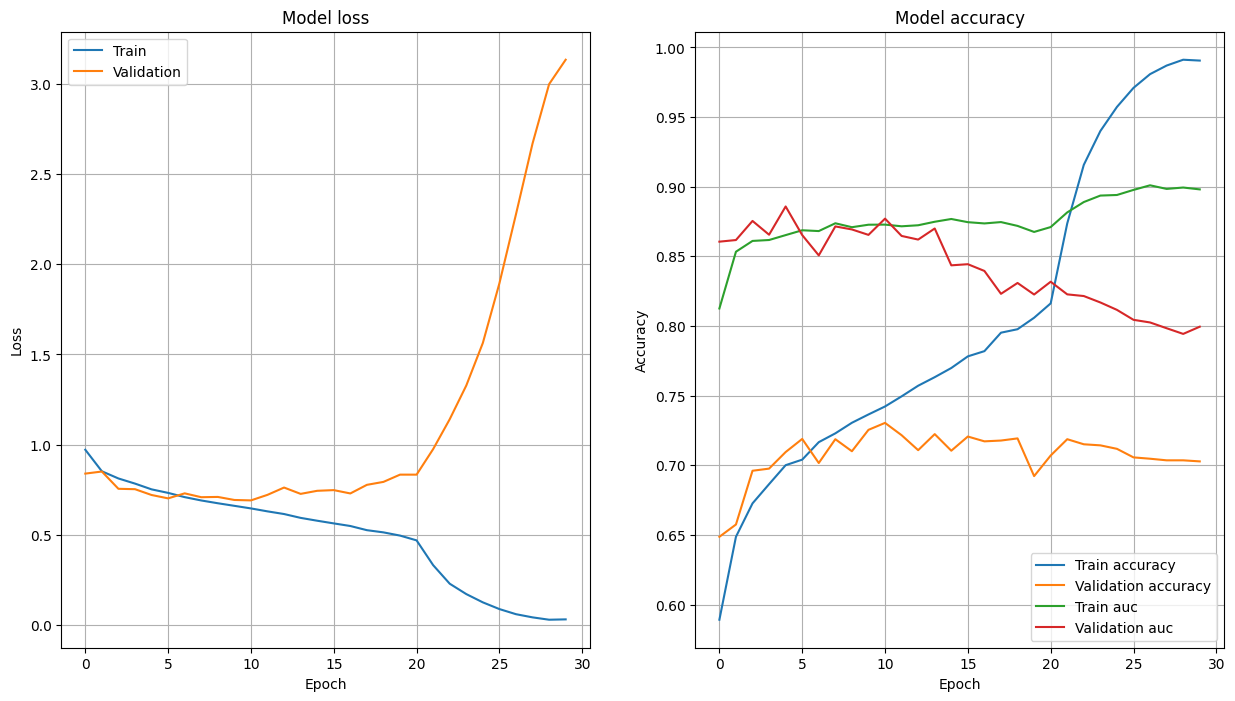

In [ ]:
plot_history(history_class)

## **Downloading a pretrained model, predictind and evaluating the model**

In [ ]:
model_name = "model_20230209-194541_100_0.907.tf"
MODEL_PATH = f"{base_path}/{folder_name}/{model_name}"

In [ ]:
# sample configuration
NUMBATCHES = 1 
BATCH_SIZE = 10
INPUT_IMAGE_SIZE = (64, 64)
OUTPUT_IMAGE_SIZE = (64, 64)